# Generative Models Project, Diffusion vs. PixelCNN
I adapted/sourced much of this code from a public repo by Shekhar Jha, so thanks to him for his informative project.

# Setup I

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
# Set the project folder path
project_folder = '/content/drive/MyDrive/ec147/ec147final_proj/pixel-cnn-master'
# Change the current working directory to the project folder
os.chdir(project_folder)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/MyDrive/ec147/ec147final_proj/pixel-cnn-master


# Setup II (torch and project imports)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from model import PixelCNN

In [ ]:
try :
  import torchinfo # if already installed
except :
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

# Setup III (CIFAR data imports and model init)

In [ ]:
# importing dataset (CIFAR10 to start)
dataset = datasets.CIFAR10(root='cifar10',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

# review how this data is stored and if it is possibly segregatable



Files already downloaded and verified


In [ ]:
# trainloader settings and such

BATCH_SIZE = 32 # for now
chans = 3 # RGB channels
im_h = 32 # 32 pixels tall
im_w = 32 # 32 pixels wide

In [ ]:
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'trainloader info: {type(trainloader)}, ') # sanity check

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PixelCNN().to(device) # instantiating model

# # loss function, LR, chosen optimizer (for training on CIFAR-10)

# criterion = nn.CrossEntropyLoss() # criterion for evaluating PixelCNN
criterion = nn.L1Loss()


LEARNING_RATE = 1e-3 # original learning rate from paper
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))


trainloader info: <class 'torch.utils.data.dataloader.DataLoader'>, 


In [ ]:
# what does our model actually look like?
from model import PixelCNN
model.train() # train mode to use summary()
summary(model, input_size=[1, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
PixelCNN                                 [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 256, 32, 32]          --
│    └─MaskedConv2d: 2-1                 [1, 256, 32, 32]          37,888
│    └─BatchNorm2d: 2-2                  [1, 256, 32, 32]          512
│    └─ReLU: 2-3                         [1, 256, 32, 32]          --
├─Sequential: 1-2                        [1, 256, 32, 32]          --
│    └─MaskBConvBlock: 2-4               [1, 256, 32, 32]          --
│    │    └─Sequential: 3-1              [1, 256, 32, 32]          214,528
├─Sequential: 1-3                        [1, 768, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 1024, 32, 32]         263,168
│    └─BatchNorm2d: 2-6                  [1, 1024, 32, 32]         2,048
│    └─ReLU: 2-7                         [1, 1024, 32, 32]         --
│    └─Conv2d: 2-8                       [1, 768, 32, 32]          

# Training and sampling functions, we leverage torchvision for sampling.

In [ ]:
import torchvision.utils as utils  # Import the specific submodule for save_image

def train(trainloader):
    '''
    trains the model through a batch. Called for all batches in an epoch.
    inputs :
      trainloader : torch.DataLoader object trained with
    '''
    print('PIXEL-CNN TRAINING INITIATED...\n')

    model.train() # setting model to train mode

    #summary(model) # i think model needs to be in train mode for me to use this

    for idx, data in enumerate(trainloader):

        if idx%100==0 :
          print('Processing batch {}...'.format(idx+1))  # Track batch progress

        # recall, trainloader is the dataloader object from the data set
        # it allows us to easily shuffle and move through the data set during
        # training

        # # after using the transforms in importing the data, img is normalized to 0-1
        try:
          img, _ = data # unpacking image data, if we also have label attached
        except:
          img = data  # Assuming the dataset returns only the image

        # in the event that if img is a list
        if isinstance(img, list):

            img = torch.cat(img, dim=0) # Concatenate list of tensors

        img = img.to(device) # moving the data to desired computing device

        # print(f'img.shape is {img.shape}')

        optimizer.zero_grad() # resets gradients to zero
        output = model(img) # computing predicted pixel probabilities

        #print(f'output type is : {type(output)} \n output shape : {output.shape}')


        reordered_output = torch.permute(output, (0, 2, 3, 1))
        reordered_img = torch.permute(img, (0, 3, 2, 1))

        data_type = reordered_img.dtype

        # Option 2: Rounding for integer conversion
        # reordered_img = torch.round(reordered_img).float()


        # I opted to round rather than truncate

        # calculating loss according to

        # print(f'shapes : {reordered_output.shape}, {reordered_img.shape}')
        loss = criterion(reordered_output, reordered_img)
        # specified loss function (L1 loss, now)

        loss.backward() # back-prop step
        optimizer.step() # gradient update

        # probe gradients at certain batches ...
        PROBE_GRADS = 0
        if idx%100==0 and PROBE_GRADS:

          for name, param in model.named_parameters():
              if param.grad is not None:
                  print(f"\t{name}: Update = {param.grad.mean().item():.4f}")

    return loss

softmax = nn.Softmax(dim=1)

import torch.nn.functional as F

def sample(sample, epoch):
    '''
    samples the model's output given a stage in training
    inputs :
      sample : the output image tensor to be saved
      epoch : epoch number for naming
    '''
    with torch.no_grad():

        for i in range(32):

            for j in range(32):
                out = model(sample)
                probs = softmax(out[:, :, i, j]).data  # Apply softmax along channel dimension

                # Use argmax sampling
                for k in range(3):

                    pixel_index = probs[:, k].max()
                    pixel = pixel_index.float()

                    # Set the pixel value only if the probability is non-zero
                    if probs[:, k].max() > 0:
                        sample[:, k, i, j] = pixel.view(-1)

                    sample[:, k, i, j] = pixel.view(-1)

    #utils.save_image(sample, 'sample_forFID{}.png'.format(epoch), nrow=8, padding=0)


# Fixed image input :
(One for general sampling purposes, as themodel starts as image of zeros (black square)

(A second to test the hypotheses described below)

From this blog : https://sergeiturukin.com/2017/02/22/pixelcnn.html

(regarding the inference step)

**Inference**


Since PixelCNN is autoregressive model inference happens to be sequential: we have to generate sample by sample. First, we generate image by passing all-zeros to our model. It shouldn’t influence the very first pixel as its value (to be strict R channel value) is modelled to be independent of anything. So, we perform forward pass and obtain distribution for it. Given the distribution we sample a value using sample_from function (see wavenet/utils.py#32). Then we update our image with that value and continue with G channel value. We iterate until we have all pixel values generated.

It’s worth noting that generation would require 3 * HEIGHT * WIDTH model runs (3072 for CIFAR) and it can’t be parallelized. Not very scalable. However, we still can pass a batch to generate several images simultaneously. Stochastic nature of sample_from routine will help us to get different images.

---



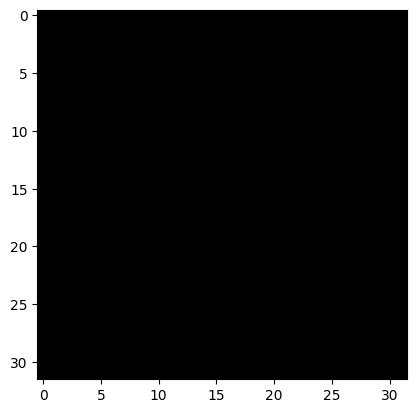

In [ ]:
import matplotlib.pyplot as plt


# initializing empty image
zeroes_img_tensor = torch.zeros(1, 3, 32, 32)  # RGB image with 3 channels

# Initialize an empty tensor to represent the image
zeroes_img_tensor = torch.zeros(1, 3, 32, 32)  # RGB image with 3 channels

# Generate your image with PixelCNN model
# Your code for generating the image goes here...

# Convert to NumPy array for visualization
image_array = zeroes_img_tensor.squeeze(0).permute(1, 2, 0).numpy()
# Here, we squeeze the batch dimension and permute the dimensions to match matplotlib's format

# Display the image using matplotlib
plt.imshow(image_array)
plt.show()

# Grabbing random image to train exclusively on :
The motivation here is to determine whether or not PixelCNN fails to learn well on the full dataset (it is composed of many class, after all) or if it CAN perform better than the 200 epoch test would suggest.

We will train EXCLUSIVELY on a SINGLE image (and then perhaps later, a single class) to determine the the validity of these hypothesis:

(1) PixelCNN is limited, but can learn a class at a time.

(2) This implementation of PixelCNN is an underperforming model.

In [ ]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt

# new instance of cifar-10 dataset
cif_for_sing_img = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


Random Class Index: 4
Random Image Index: 27302


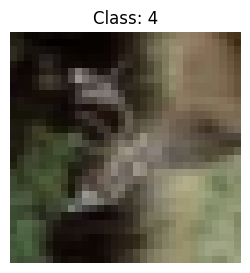

In [ ]:
# Choose a random class
random_class_index = random.randint(0, 9)  # There are 10 classes in CIFAR-10
print("Random Class Index:", random_class_index)

# Filter dataset for images belonging to the chosen class
class_indices = [i for i, (_, label) in enumerate(cif_for_sing_img) if label == random_class_index]

# Randomly select an image from the chosen class
random_image_index = random.choice(class_indices)
print("Random Image Index:", random_image_index)

# Access the randomly selected image and its label
random_image, label = cif_for_sing_img[random_image_index]

# Visualize the randomly selected image
plt.figure(figsize=(3, 3))
plt.imshow(torch.transpose(random_image, 0, 2))  # Transpose image tensor to (height, width, channels) for visualization
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()


In [ ]:
# setting fixed_input with an empty tensor to represent the initial image

fixed_input = zeroes_img_tensor # fixed_input for sampling

# fixed_imipII is for the single image training test...
fixed_imipII = random_image

# Moving fixed_input tensors to the same device as the model
fixed_input = fixed_input.to(device)
fixed_imipII = fixed_imipII.to(device)

In [ ]:
# building a trainloader ONLY containing one image so I don't
# give my training loop indigestion

import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming fixed_imipII is your single image tensor
#print(f'fixed_imipII.shape is : {fixed_imipII.shape}')  # Sanity check

# Add a batch dimension of 1 to the image tensor
image_tensor_batch = fixed_imipII.unsqueeze(0)

# Create a dataset with the image tensor
dataset = TensorDataset(image_tensor_batch)

# Create a DataLoader object from the dataset
batch_size = 1  # Set batch_size to 1
fixed_imipII_trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print the type of fixed_imipII_trainloader
print(type(fixed_imipII_trainloader))

# Print the shape of the image tensor in the DataLoader
for images in fixed_imipII_trainloader:
    # images is a batch of image tensors (in this case, just one image tensor)
    image_tensor = images[0]  # Get the image tensor from the batch
    print(image_tensor.shape)


<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([1, 3, 32, 32])


# Training Routine

on all the images

In [ ]:
from model import PixelCNN # forcing it to using update version
import numpy as np

num_epochs = 50
losses = []

# training loop
for epoch in range(num_epochs):
    print(f'AT EPOCH {epoch} / {num_epochs} : {epoch/num_epochs*100:.2f}%')

    train_loss = train(trainloader) # calling above training function
    losses.append(train_loss)

    print('[{}/{}]  loss: {}'.format(epoch+1, num_epochs, train_loss))

    if epoch%50000==0:
      sample(fixed_input, epoch) # for grabbing png

# Move the losses tensor to CPU
losses_cpu = [loss.cpu().item() for loss in losses]

# Plot the losses
plt.plot(np.arange(1, num_epochs + 1), losses_cpu, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')

plt.legend()
plt.show()


AT EPOCH 0 / 50 : 0.00%
PIXEL-CNN TRAINING INITIATED...

Processing batch 1...
Processing batch 101...
Processing batch 201...
Processing batch 301...
Processing batch 401...
Processing batch 501...
Processing batch 601...
Processing batch 701...
Processing batch 801...
Processing batch 901...
Processing batch 1001...
Processing batch 1101...
Processing batch 1201...
Processing batch 1301...
Processing batch 1401...
Processing batch 1501...
[1/50]  loss: 0.1852569431066513
AT EPOCH 1 / 50 : 2.00%
PIXEL-CNN TRAINING INITIATED...

Processing batch 1...
Processing batch 101...
Processing batch 201...
Processing batch 301...
Processing batch 401...
Processing batch 501...
Processing batch 601...
Processing batch 701...
Processing batch 801...
Processing batch 901...
Processing batch 1001...
Processing batch 1101...
Processing batch 1201...
Processing batch 1301...
Processing batch 1401...
Processing batch 1501...
[2/50]  loss: 0.1877383589744568
AT EPOCH 2 / 50 : 4.00%
PIXEL-CNN TRAINING I

KeyboardInterrupt: 

on a single image for 50

# fixed_input thing :

In [ ]:
fixed_input = fixed_input.to('cuda')  # Assuming your model is on 'cuda' device
sample(fixed_input, 57) # compartmentalized so I don't have to keep training over and over


# Optimizing Learning Rate :

Testing Learning Rate: 0.1
Epoch [1/5]
	Batch [100/1563], Loss: 51.000901
	Batch [200/1563], Loss: 0.108165
	Batch [300/1563], Loss: 0.099064
	Batch [400/1563], Loss: 0.097423
	Batch [500/1563], Loss: 0.100518
	Batch [600/1563], Loss: 0.099834
	Batch [700/1563], Loss: 0.091385
	Batch [800/1563], Loss: 0.096512
	Batch [900/1563], Loss: 0.092803
	Batch [1000/1563], Loss: 0.090069
	Batch [1100/1563], Loss: 0.081205
	Batch [1200/1563], Loss: 0.081748
	Batch [1300/1563], Loss: 0.076799
	Batch [1400/1563], Loss: 0.067147
	Batch [1500/1563], Loss: 0.080491
	Epoch [1/5], Average Loss: 0.002964
Epoch [2/5]
	Batch [100/1563], Loss: 0.072442
	Batch [200/1563], Loss: 0.093353
	Batch [300/1563], Loss: 0.133700
	Batch [400/1563], Loss: 0.079259
	Batch [500/1563], Loss: 0.126643
	Batch [600/1563], Loss: 0.178427
	Batch [700/1563], Loss: 0.147609
	Batch [800/1563], Loss: 0.079540
	Batch [900/1563], Loss: 0.142532
	Batch [1000/1563], Loss: 0.229812
	Batch [1100/1563], Loss: 0.223454
	Batch [1200/1563],

KeyboardInterrupt: 

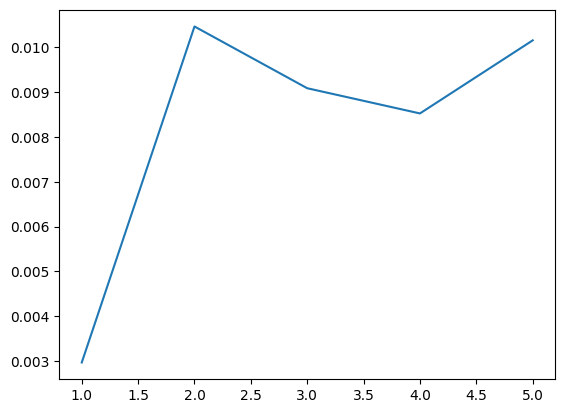

In [ ]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
num_epochs = 5

for LR in learning_rates:
    print(f"Testing Learning Rate: {LR}")

    model = PixelCNN().to(device) # instantiating model

    # # loss function, LR, chosen optimizer (for training on CIFAR-10)
    criterion = nn.L1Loss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))

    losses = []
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, inputs)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'\tBatch [{i+1}/{len(trainloader)}], Loss: {running_loss / 100:.6f}')
                running_loss = 0.0

        # Record the average loss for this epoch
        epoch_loss = running_loss / (i + 1)
        losses.append(epoch_loss)
        print(f'\tEpoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.6f}')

    # Plot the losses for this learning rate
    plt.plot(range(1, num_epochs + 1), losses, label=f'LR: {LR}')

# Plot settings
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.show()